In [1]:
# packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import pandas as pd
import os
from itertools import combinations
import h5py

import sys
sys.path.append("../src")

from analysis import *
from inference import *

In [2]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)] 
    return sorted(l, key=alphanum_key)

In [3]:
datapath = "../experiment_outputs/perturb_no_noise_env_noise0.0"
log = h5py.File(f"{datapath}/data_generation_log.h5", "r")

print(f"n_species = {log.attrs['n_species']}")
print(f"avg_samp_dt = {log.attrs['avg_samp_dt']}")
print(f"env_noise = {log.attrs['env_noise']}")
print(f"meas_noise_list = {log.attrs['meas_noise_list']}")
print(f"n_params_seeds = {log.attrs['n_params_seeds']}")

n_species = [10]
avg_samp_dt = [3.  1.5 1. ]
env_noise = 0.0
meas_noise_list = [0.]
n_params_seeds = 5


In [4]:
n_sp = 10
# avg_samp_dt = 3.
env_noise = log.attrs["env_noise"]
meas_noise = log.attrs['meas_noise_list'][0]
n_params_seeds = log.attrs['n_params_seeds']
params_seeds = [i.split("param_seed")[1] for i in os.listdir(f"{datapath}/{n_sp}_sp")]

In [5]:
def get_files(datapath, n_sp, env_noise, meas_noise, avg_samp_dt, filetype="dataset", ext="csv"):
    params_seeds = [i.split("param_seed")[1] for i in os.listdir(f"{datapath}/{n_sp}_sp")]

    datafiles = []

    for p in params_seeds:
        datafiles.append(f"{datapath}/{n_sp}_sp/param_seed{p}/meas_noise{meas_noise}/t_samp{avg_samp_dt}/{filetype}{n_sp}_sp{p}_env_noise{env_noise}.{ext}")
    
    return datafiles

In [6]:
datafiles = [get_files(datapath, n_sp, env_noise, meas_noise, i) for i in log.attrs["avg_samp_dt"]]

inferfiles = [get_files(datapath, n_sp, env_noise, meas_noise, i, "inference") for i in log.attrs["avg_samp_dt"]]

metadatafiles = [get_files(datapath, n_sp, env_noise, meas_noise, i, "metadata", "txt") for i in log.attrs["avg_samp_dt"]]

In [7]:
print(f"Numbers of sampling points: {log.attrs['n_samples']}")
print(f"Average sampling intervals: {log.attrs['avg_samp_dt'].round(3)}")
print(f"Number of initial conditions: {log.attrs['n_init_cond']}")
print(f"Number of repetitions: {log.attrs['repetitions']}")
print(f"Environmental noise: {log.attrs['env_noise']}")
print(f"Amounts of measurement noise: {log.attrs['meas_noise_list']}")

Numbers of sampling points: [11 21 31]
Average sampling intervals: [3.  1.5 1. ]
Number of initial conditions: 10
Number of repetitions: 1
Environmental noise: 0.0
Amounts of measurement noise: [0.]


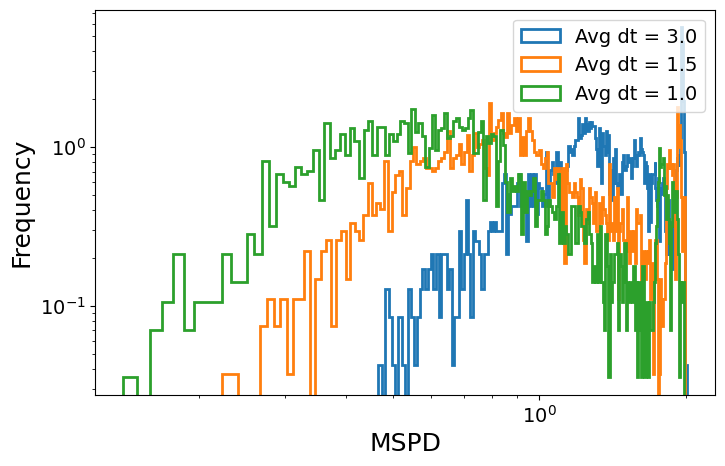

In [8]:
# MSPD frequency
plt.figure(figsize=(8,5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0) for i in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.MSPD.values, 200,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}", 
             lw=2, density=True)
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("MSPD", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [9]:
!ls ../experiment_outputs/perturb0_env_noise0.1/10_sp/param_seed0/meas_noise0.1/t_samp3.0/

dataset10_sp0_env_noise0.1.csv	  metadata10_sp0_env_noise0.1.txt
inference10_sp0_env_noise0.1.csv


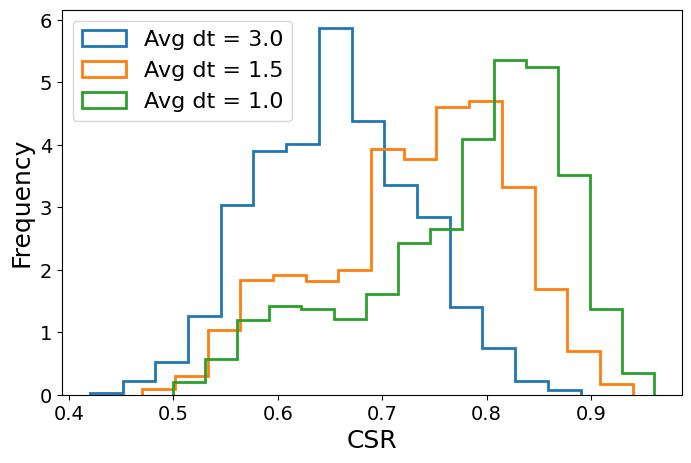

In [10]:
# CSR frequency over n_tpoints

plt.figure(figsize=(8, 5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0) for i in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.CSR.values, 15,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("CSR", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

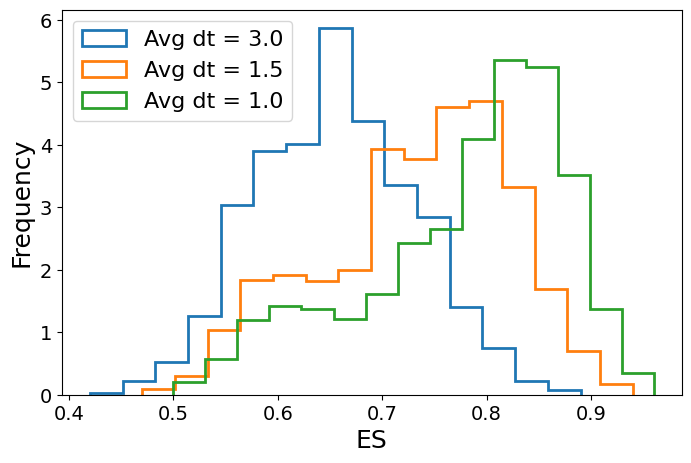

In [11]:
# ES frequency over n_tpoints

plt.figure(figsize=(8, 5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0) for i in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.ES.values, 15,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("ES", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [12]:
# Difference between CSR and ES scores
# Difference between CSR and ES scores
df = pd.concat([pd.read_csv(i, index_col=0) for i in inferfiles[0]], axis=0).reset_index(drop=True)
print((df.CSR!=df.ES).sum())
df = pd.concat([pd.read_csv(i, index_col=0) for i in inferfiles[1]], axis=0).reset_index(drop=True)
print((df.CSR!=df.ES).sum())

0
0


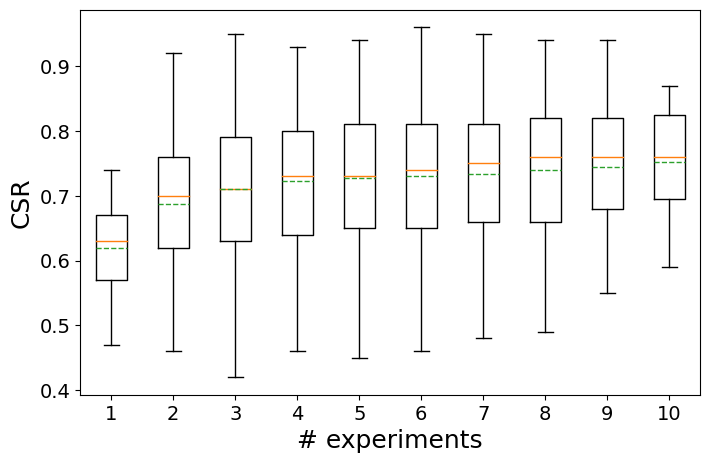

In [13]:
# CSR boxplots over # of experiments
df = pd.concat([pd.read_csv(i, index_col=0) for i in np.concatenate(inferfiles)], axis=0).reset_index(drop=True)
CSR = [df[df.n_init_cond==i]["CSR"].values for i in df.n_init_cond.unique()]

plt.figure(figsize=(8,5))
plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

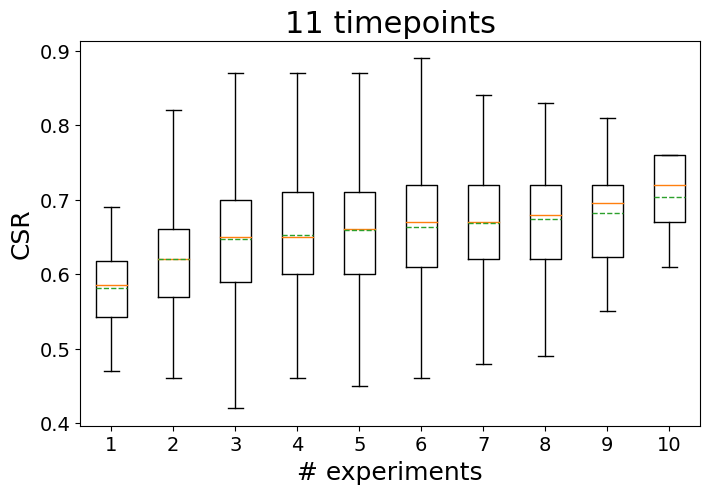

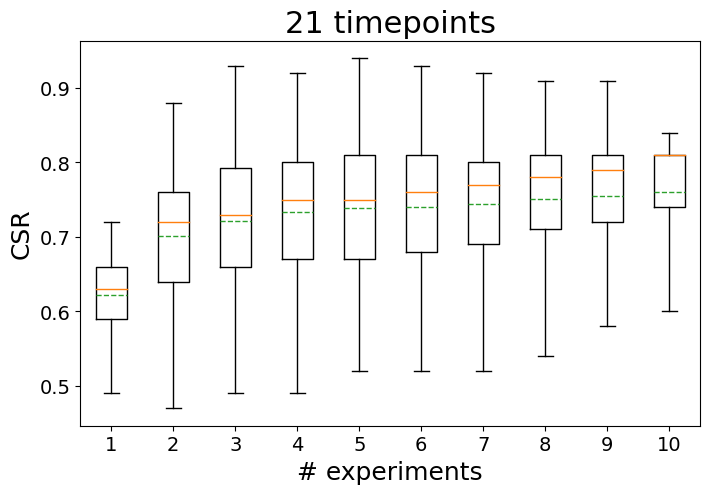

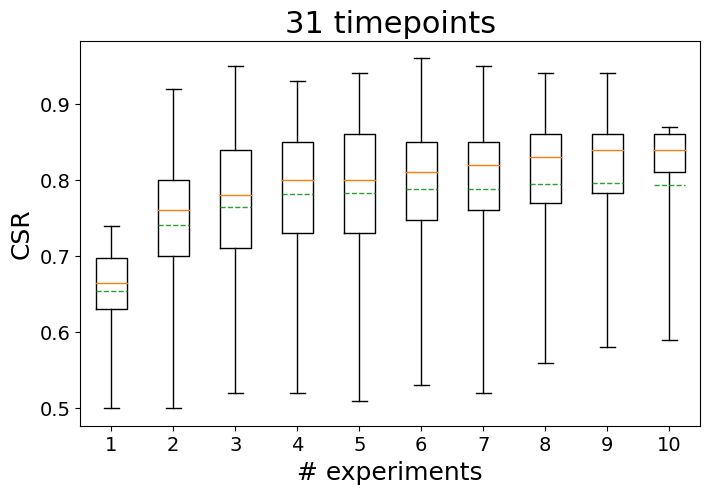

In [14]:
# CSR boxplot over # of experiments, by n_tpoints
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0) for i in inferfiles[i]], axis=0).reset_index(drop=True)

    CSR = [df[df["n_init_cond"]==i]["CSR"].values for i in df.n_init_cond.unique()]

    plt.figure(figsize=(8,5))
    plt.title(f"{log.attrs['n_samples'][i]} timepoints", fontsize=22)
    plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
    plt.xlabel("# experiments", fontsize=18)
    plt.ylabel("CSR", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

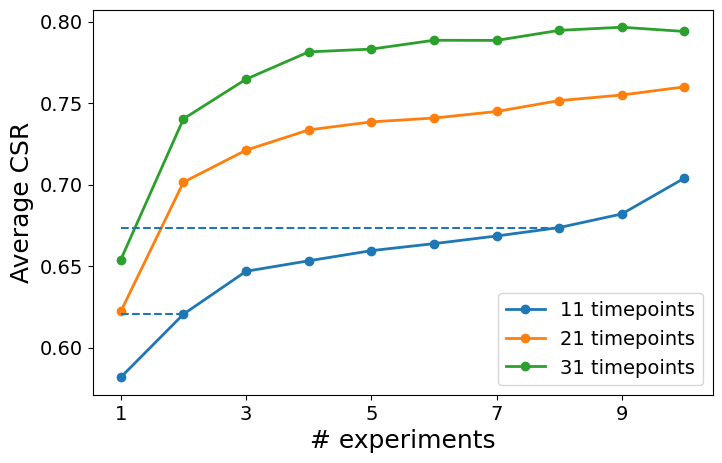

In [15]:
# average CSR over time
avgCSR = np.zeros((len(log.attrs["avg_samp_dt"]), log.attrs["n_init_cond"]))
for i in range(len(log.attrs["avg_samp_dt"])):
    df = pd.concat([pd.read_csv(k, index_col=0) for k in inferfiles[i]], axis=0).reset_index(drop=True)
    
    for j in range(log.attrs["n_init_cond"]):
        n_init_cond = df["n_init_cond"].unique()[j]
        avgCSR[i,j] = df[df["n_init_cond"]==n_init_cond]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8,5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1), avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0,i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.show()

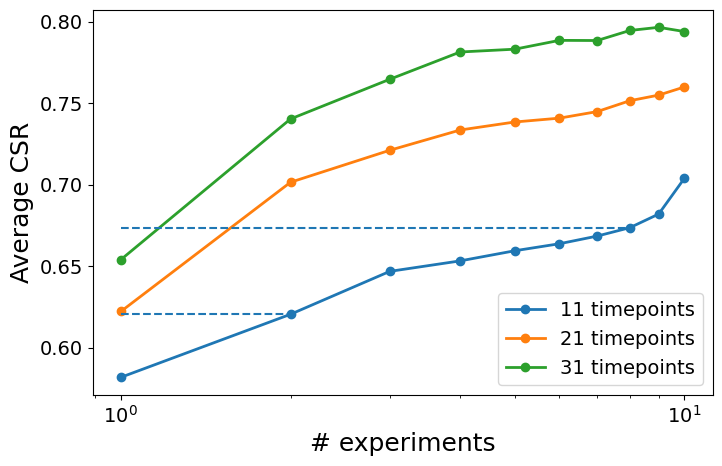

In [16]:
# average CSR over time
avgCSR = np.zeros((len(log.attrs["avg_samp_dt"]), log.attrs["n_init_cond"]))
for i in range(len(log.attrs["avg_samp_dt"])):
    df = pd.concat([pd.read_csv(k, index_col=0) for k in inferfiles[i]], axis=0).reset_index(drop=True)
    
    for j in range(log.attrs["n_init_cond"]):
        n_init_cond = df["n_init_cond"].unique()[j]
        avgCSR[i,j] = df[df["n_init_cond"]==n_init_cond]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8,5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1), avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0,i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.xscale("log")
plt.show()

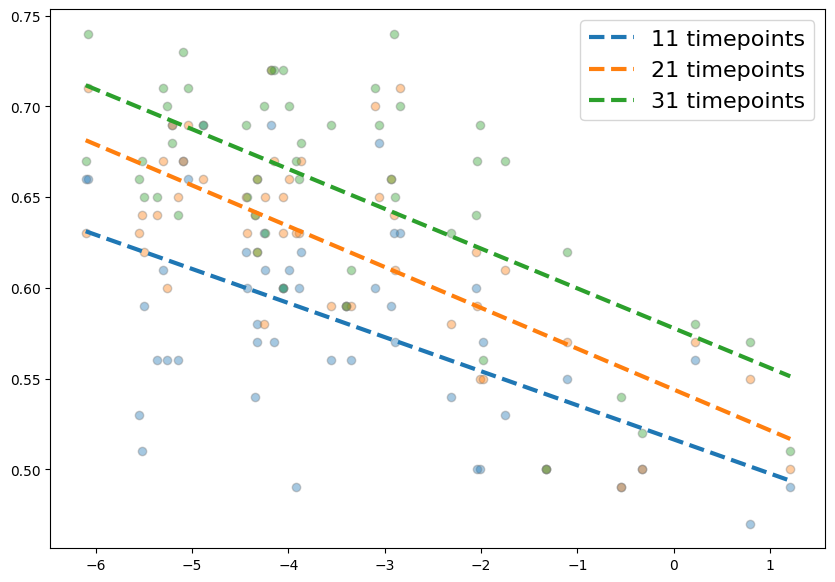

In [17]:
plt.figure(figsize=(10,7))

for j in range(len(log.attrs["n_samples"])):
    init_cond_msd = []
    csr = []

    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        df_tmp = df[df["n_init_cond"]==1]
        
        init_cond_idx = [int(re.findall("([0-9]+).0", i)[0]) for i in df_tmp.init_cond_idx]
        init_cond = metadict["init_cond"][init_cond_idx]

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        init_cond_msd.append(((init_cond-x_eq)**2).mean(axis=1))
        csr.append(df_tmp.CSR.values)

        plt.scatter(np.log(((init_cond-x_eq)**2).mean(axis=1)), df_tmp.CSR, 
                    facecolors=f"C{j}", alpha=0.4, edgecolors="gray")

    init_cond_msd = np.concatenate(init_cond_msd)
    csr = np.concatenate(csr)

    reg = lm.LinearRegression()
    reg.fit(np.log(init_cond_msd).reshape((-1,1)), csr)
    plt.plot([np.log(init_cond_msd).min(), np.log(init_cond_msd).max()], 
             reg.predict([[np.log(init_cond_msd).min()], [np.log(init_cond_msd).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

# plt.xlabel()
plt.legend(fontsize=16)
plt.show()

In [18]:
def distances(m):
    n = 0
    avg_dist = 0
    for i in range(m.shape[0]-1):
        for j in range(i, m.shape[0]):
            n += 1
            avg_dist += (np.linalg.norm(m[i]-m[j])-avg_dist)/n

    return avg_dist

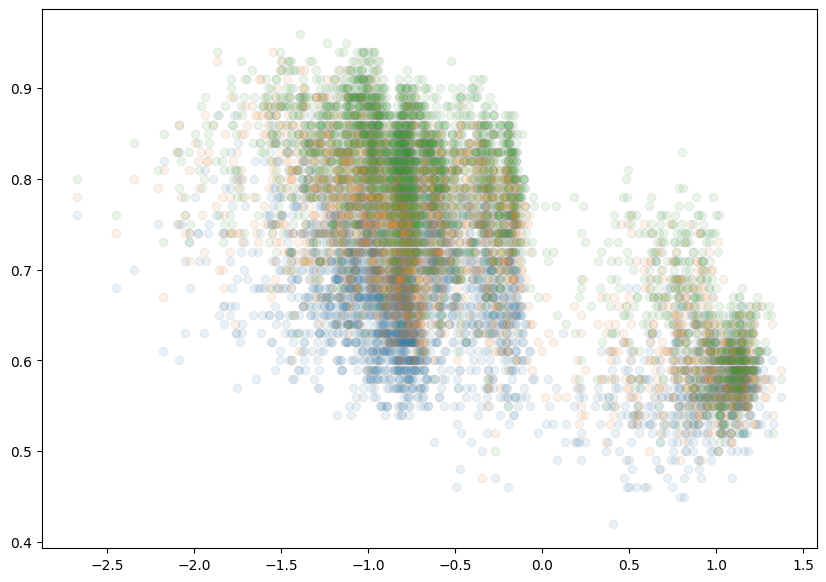

In [30]:
plt.figure(figsize=(10,7))

for j in range(len(log.attrs["n_samples"])):
    total_init_cond_dot = []
    total_csr = []
    
    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        for n in range(2, 11):
            df_tmp = df[df["n_init_cond"]==n]
            
            init_cond_idx = [[int(m) for m in re.findall("([0-9]+).0", i)] for i in df_tmp.init_cond_idx.values]
            
            init_cond_x_eq_dot_mean = []
            csr = []

            for l in range(len(init_cond_idx)):
                init_cond = metadict["init_cond"][init_cond_idx[l]]

                init_cond_x_eq_dot_mean.append(distances(init_cond))
                csr.append(df_tmp.CSR.values[l])

            init_cond_x_eq_dot_mean = np.array(init_cond_x_eq_dot_mean)
            csr = np.array(csr)

            total_init_cond_dot.append(init_cond_x_eq_dot_mean)
            total_csr.append(csr)

    total_init_cond_dot = np.concatenate(total_init_cond_dot)
    total_csr = np.concatenate(total_csr)

    plt.scatter(np.log(total_init_cond_dot), total_csr, 
                        c=f"C{j}", alpha=0.1, edgecolors="gray")

    # reg = lm.LinearRegression()
    # reg.fit((total_init_cond_dot).reshape((-1,1)), total_csr)
    # plt.plot([(total_init_cond_dot).min(), (total_init_cond_dot).max()], 
    #          reg.predict([[(total_init_cond_dot).min()], [(total_init_cond_dot).max()]]),
    #          ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

# plt.xlabel("Log(variance of initial condition set)", fontsize=18)
# plt.ylabel("CSR", fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=16)
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


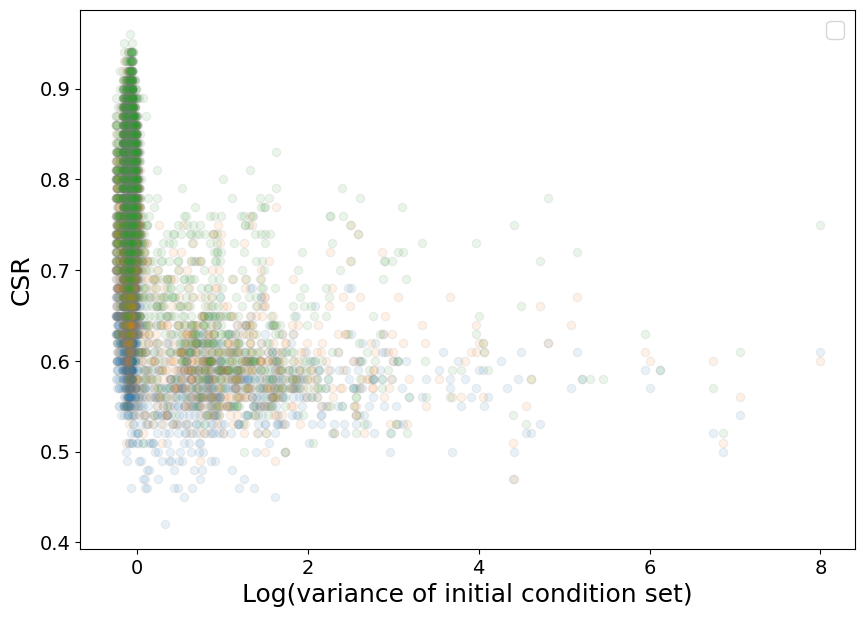

In [37]:
plt.figure(figsize=(10,7))

for j in range(len(log.attrs["n_samples"])):
    total_init_cond_dot = []
    total_csr = []
    
    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        for n in range(2, 21):
            df_tmp = df[df["n_init_cond"]==n]
            
            init_cond_idx = [[int(m) for m in re.findall("([0-9]+).0", i)] for i in df_tmp.init_cond_idx.values]
            
            init_cond_x_eq_dot_mean = []
            csr = []

            for l in range(len(init_cond_idx)):
                init_cond = metadict["init_cond"][init_cond_idx[l]]

                init_cond_x_eq = init_cond-x_eq
                norm_init_cond_x_eq = init_cond_x_eq #/ np.linalg.norm(init_cond_x_eq, axis=1).reshape((-1,1))

                norm_init_cond_x_eq_dot = norm_init_cond_x_eq.dot(norm_init_cond_x_eq.T)

                init_cond_x_eq_dot_mean.append((norm_init_cond_x_eq_dot-np.eye(norm_init_cond_x_eq_dot.shape[0])).mean()/2)
                csr.append(df_tmp.CSR.values[l])

            init_cond_x_eq_dot_mean = np.array(init_cond_x_eq_dot_mean)
            csr = np.array(csr)

            total_init_cond_dot.append(init_cond_x_eq_dot_mean)
            total_csr.append(csr)

    total_init_cond_dot = np.concatenate(total_init_cond_dot)
    total_csr = np.concatenate(total_csr)

    plt.scatter((total_init_cond_dot), total_csr, 
                        c=f"C{j}", alpha=0.1, edgecolors="gray")

    # reg = lm.LinearRegression()
    # reg.fit((total_init_cond_dot).reshape((-1,1)), total_csr)
    # plt.plot([(total_init_cond_dot).min(), (total_init_cond_dot).max()], 
    #          reg.predict([[(total_init_cond_dot).min()], [(total_init_cond_dot).max()]]),
    #          ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

plt.xlabel("Log(variance of initial condition set)", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

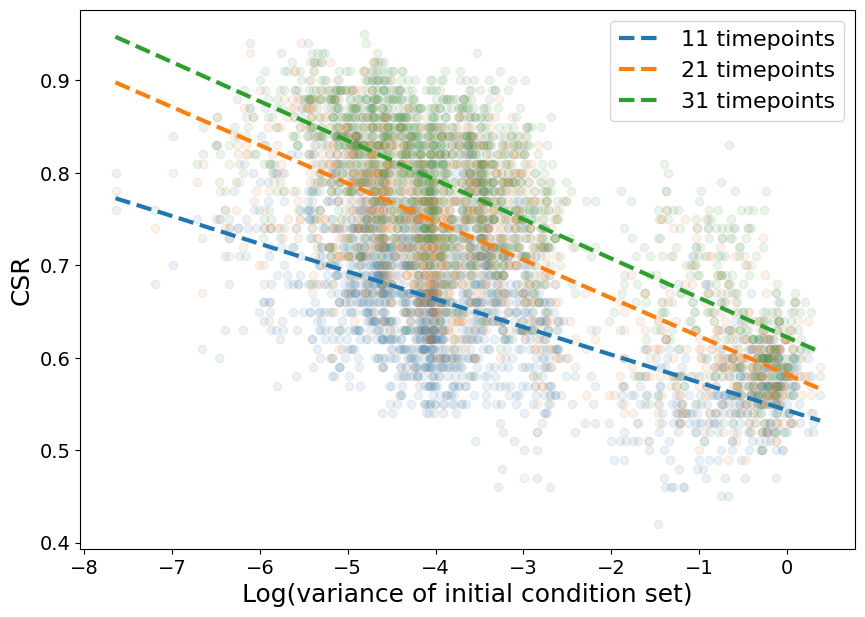

In [22]:
plt.figure(figsize=(10,7))

for j in range(len(log.attrs["n_samples"])):
    total_init_cond_var = []
    total_csr = []
    
    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        for n in range(2, 6):
            df_tmp = df[df["n_init_cond"]==n]
            
            init_cond_idx = [[int(m) for m in re.findall("([0-9]+).0", i)] for i in df_tmp.init_cond_idx.values]
            
            init_cond_var = []
            csr = []

            for l in range(len(init_cond_idx)):
                init_cond = metadict["init_cond"][init_cond_idx[l]]

                init_cond_var.append(init_cond)#-x_eq)
                csr.append(df_tmp.CSR.values[l])

            init_cond_var = np.array(init_cond_var).var(axis=1).mean(axis=1)
            csr = np.array(csr)

            total_init_cond_var.append(init_cond_var)
            total_csr.append(csr)

    total_init_cond_var = np.concatenate(total_init_cond_var)
    total_csr = np.concatenate(total_csr)

    plt.scatter(np.log(total_init_cond_var), total_csr, 
                        c=f"C{j}", alpha=0.1, edgecolors="gray")

    reg = lm.LinearRegression()
    reg.fit(np.log(total_init_cond_var).reshape((-1,1)), total_csr)
    plt.plot([np.log(total_init_cond_var).min(), np.log(total_init_cond_var).max()], 
             reg.predict([[np.log(total_init_cond_var).min()], [np.log(total_init_cond_var).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

plt.xlabel("Log(variance of initial condition set)", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

In [23]:
# CSR ratios

tpoints_ratio01 = []
CSR_ratio01 = []
tpoints_ratio02 = []
CSR_ratio02 = []
tpoints_ratio12 = []
CSR_ratio12 = []

for i in range(len(avgCSR[0])):
    for j in range(len(avgCSR[1])):
        tpoints_ratio01.append(20*(j+1)/(10*(i+1)))
        CSR_ratio01.append(avgCSR[1,j]/avgCSR[0,i])
        tpoints_ratio02.append(30*(j+1)/(10*(i+1)))
        CSR_ratio02.append(avgCSR[2,j]/avgCSR[0,i])
        tpoints_ratio12.append(30*(j+1)/(20*(i+1)))
        CSR_ratio12.append(avgCSR[2,j]/avgCSR[1,i])

tpoints_ratio01 = np.array(tpoints_ratio01)
CSR_ratio01 = np.array(CSR_ratio01)
tpoints_ratio02 = np.array(tpoints_ratio02)
CSR_ratio02 = np.array(CSR_ratio02)
tpoints_ratio12 = np.array(tpoints_ratio12)
CSR_ratio12 = np.array(CSR_ratio12)

tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))

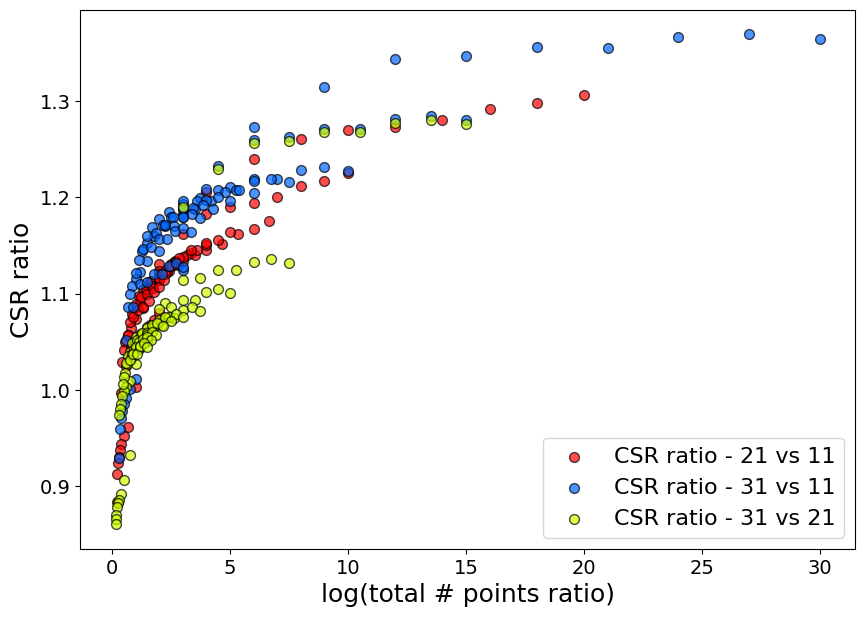

In [24]:
# CSR_ratio vs tpoints ratio
plt.figure(figsize=(10,7))

#01 ---
plt.scatter(tpoints_ratio01, CSR_ratio01, facecolors=hsv_to_rgb((0,1,1)), edgecolors="k", 
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)

# 02 ---
plt.scatter(tpoints_ratio02, CSR_ratio02, facecolors=hsv_to_rgb((0.6,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)

#12 ---
plt.scatter(tpoints_ratio12, CSR_ratio12, facecolors=hsv_to_rgb((0.2,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

20 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.921573541433818
intercept = 1.05625, slope = 0.08042

--------------------------------
30 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.8991211707386736
intercept = 1.08257, slope = 0.08483

--------------------------------
30 vs 20 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.8503717916588338
intercept = 1.02834, slope = 0.07973

--------------------------------
all ratios:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.8595306821711167
intercept = 1.05159, slope = 0.08812


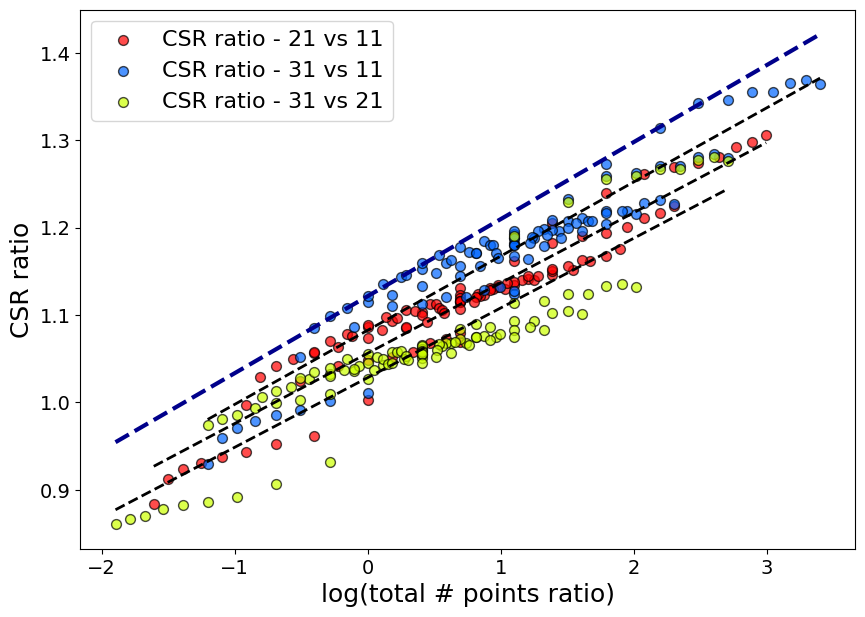

In [25]:
# CSR_ratio vs log(tpoints ratio)
plt.figure(figsize=(10,7))

#01 ---
plt.scatter(np.log(tpoints_ratio01), CSR_ratio01, facecolors=hsv_to_rgb((0,1,1)), edgecolors="k", 
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1,1)), CSR_ratio01)
x_ext = np.array([np.min(np.log(tpoints_ratio01)), np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio01).reshape((-1,1)), CSR_ratio01))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), CSR_ratio02, facecolors=hsv_to_rgb((0.6,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1,1)), CSR_ratio02)
x_ext = np.array([np.min(np.log(tpoints_ratio02)), np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio02).reshape((-1,1)), CSR_ratio02))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

#12 ---
plt.scatter(np.log(tpoints_ratio12), CSR_ratio12, facecolors=hsv_to_rgb((0.2,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1,1)), CSR_ratio12)
x_ext = np.array([np.min(np.log(tpoints_ratio12)), np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio12).reshape((-1,1)), CSR_ratio12))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

20 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9108407239257856
intercept = 0.05269, slope = 0.07309

--------------------------------
30 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.8868545036353565
intercept = 0.07874, slope = 0.07309

--------------------------------
30 vs 20 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.8537210084240587
intercept = 0.02517, slope = 0.07527

--------------------------------
all ratios:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.8553926977936168
intercept = 0.04776, slope = 0.07956


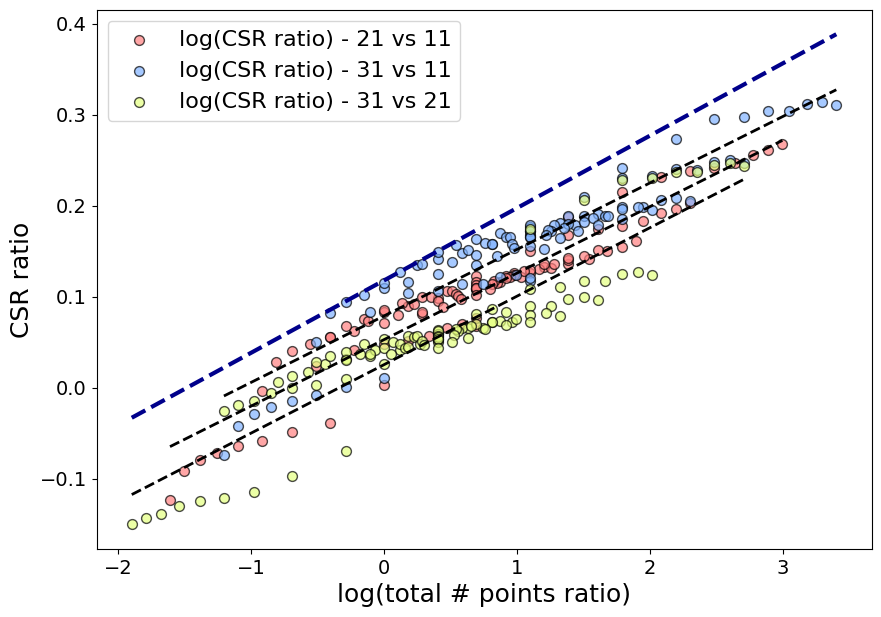

In [26]:
# log(CSR_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

#01 ---
plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01), facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1,1)), np.log(CSR_ratio01))
x_ext = np.array([np.min(np.log(tpoints_ratio01)), np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio01).reshape((-1,1)), np.log(CSR_ratio01)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02), facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1,1)), np.log(CSR_ratio02))
x_ext = np.array([np.min(np.log(tpoints_ratio02)), np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio02).reshape((-1,1)), np.log(CSR_ratio02)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

#12 ---
plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12), facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1,1)), np.log(CSR_ratio12))
x_ext = np.array([np.min(np.log(tpoints_ratio12)), np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio12).reshape((-1,1)), np.log(CSR_ratio12)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

R2 score = 0.7198533191014809


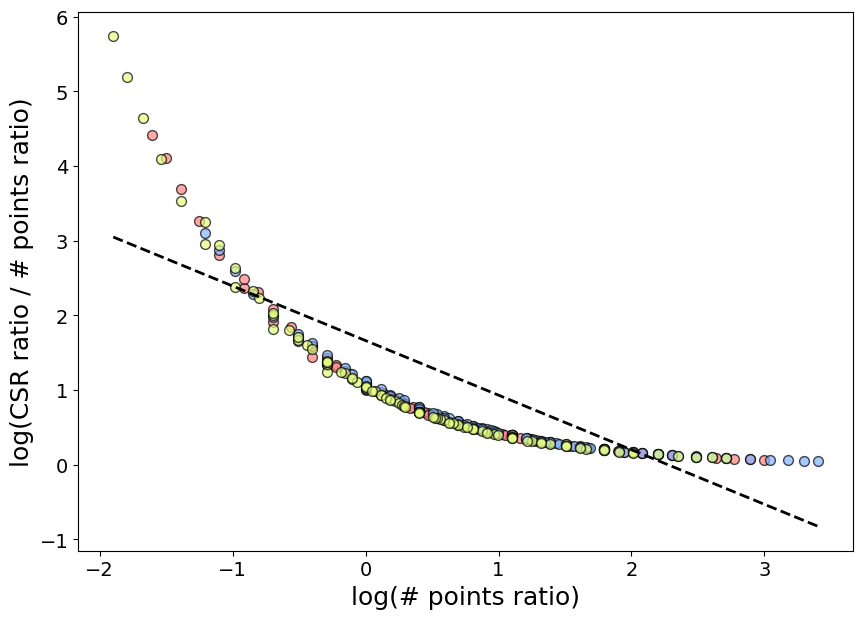

In [27]:
# CSR_ratio/tpoints_ratio vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

plt.scatter(np.log(tpoints_ratio01), CSR_ratio01/tpoints_ratio01, 
            facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), CSR_ratio02/tpoints_ratio02, 
            facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), CSR_ratio12/tpoints_ratio12, 
            facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio/tpoints_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio/tpoints_ratio))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

R2 score = 0.9987383979833437


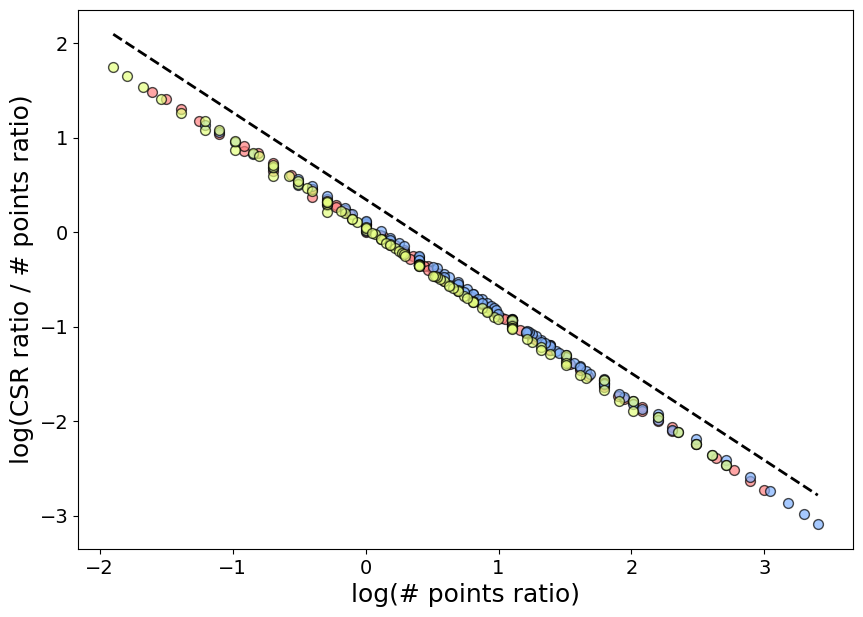

In [28]:
# log(CSR_ratio/tpoints_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01/tpoints_ratio01), 
            facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02/tpoints_ratio02), 
            facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12/tpoints_ratio12), 
            facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio/tpoints_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio/tpoints_ratio)))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()